In [1]:
#importing all the packages
import pandas as pd
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.cluster import MeanShift
from sklearn.preprocessing import MinMaxScaler

In [2]:
#importing data & merging neighbourhoods with listings
listings = pd.read_csv("Data_files/listingsUpdateOut.csv")
neighb = pd.read_csv("Data_files/neighbourhoods_update.csv", sep = ",")
main = pd.merge(listings, neighb, how="inner", on="neighbourhood_group")

#importing data & merging previous merge with sentiment
sentiment= pd.read_csv("Data_files/sentiment.csv")
sentiment= sentiment.rename(columns={"listing_id": "id"})
main2 = pd.merge(main, sentiment, how= "inner", on="id")

In [3]:
#there are 12 different municipalities
#will the clustering algorithm be able to cluster the subjects and identify 12 different groups?
#I think it is quite unlikely due to the similarities between some of the data points for each municipality

#for example, Alenquer and Azambuja are municipalities in the suburbs of Lisbon and tend to have similar cheap listings
#Lisboa and Cascais are more affluent municipalities and, consequently, tend to have similar more expensive listings

#therefore, due to the similarity between some of the municipalities, I think that if we try to cluster data based on 
#pricing and the government's coefficient of location, the clustering algorithm will end up identifying less than 12 clusters

set(list(neighb.neighbourhood_group))

{'Alenquer',
 'Amadora',
 'Azambuja',
 'Cadaval',
 'Cascais',
 'Lisboa',
 'Loures',
 'Mafra',
 'Odivelas',
 'Oeiras',
 'Sintra',
 'Torres Vedras'}

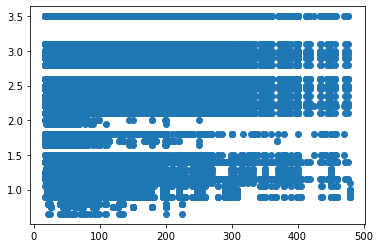

In [4]:
#selecting variables for clustering
data = main2[["price", "coefficient_of_location", "neighbourhood_group"]]
plt.scatter(main2[["price"]], main2[["coefficient_of_location"]])

#as we can see, the coefficient of location moves almost like in-steps
#notice that when the coefficient of location is below one, the prices tend to be lower
#and when it is 3.5 (the highest), there tend to be more expensive listings than in other lower levels

In [5]:
# sampling data (if we use all of it, jupyter breaks)
list1 = list(set(list(neighb.neighbourhood_group)))
list2 = []
list3 = []

#seperating dataframes by municipality and appending it to a list
for i in range(len(list1)):
    df = data.loc[data['neighbourhood_group'] == list1[i]]
    list2.append(df)

#sampling data from each municipality randomly
for i in range(len(list2)):
    sample = list2[i].sample(n=20)
    list3.append(sample)

merged = pd.DataFrame(columns = ["price", "coefficient_of_location", "neighbourhood_group"])

#merging it all into one data frame
for i in range(len(list3)):
    merged = pd.concat([list3[i], merged])

In [26]:
#now the data is fully cleaned and sampled
merged.neighbourhood_group = pd.Categorical(merged.neighbourhood_group)
merged['code'] = merged.neighbourhood_group.cat.codes
df = merged[["coefficient_of_location", "price"]]
merged

,price,coefficient_of_location,neighbourhood_group,code
196499,0.697318,0.263158,Amadora,1
196505,0.003831,0.263158,Amadora,1
196265,0.180077,0.263158,Amadora,1
196446,0.022989,0.456140,Amadora,1
196409,0.065134,0.263158,Amadora,1
...,...,...,...,...
193660,0.122605,0.368421,Oeiras,9
193819,0.141762,0.368421,Oeiras,9
193816,0.160920,0.368421,Oeiras,9
193886,0.149425,0.263158,Oeiras,9


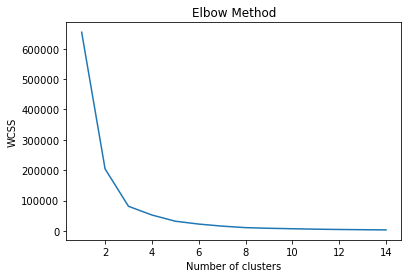

In [7]:
wcss = []

for i in range(1, 15):
    #model = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    model =KMeans(n_clusters=i, random_state=1)
    model.fit(df)
    wcss.append(model.inertia_)
plt.plot(range(1, 15), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

#as can be seen, when the data is composed of prices and coefficient of location, the elbow method signals that 4 clusters
#would be ideal, this goes in accordance with our initial suspicion

In [29]:
kmeans_model = KMeans(n_clusters=3, random_state=1).fit(df)
labels = kmeans_model.labels_
metrics.silhouette_score(df, labels, metric='euclidean')

0.783358789750113

In [27]:
# scaling data
scaler = MinMaxScaler()
scaler.fit(merged[["coefficient_of_location"]])
merged["coefficient_of_location"] = scaler.transform(merged[["coefficient_of_location"]])
scaler.fit(merged[["price"]])
merged["price"]=scaler.transform(merged[["price"]])
new_data = merged
new_data

,price,coefficient_of_location,neighbourhood_group,code
196499,0.697318,0.263158,Amadora,1
196505,0.003831,0.263158,Amadora,1
196265,0.180077,0.263158,Amadora,1
196446,0.022989,0.456140,Amadora,1
196409,0.065134,0.263158,Amadora,1
...,...,...,...,...
193660,0.122605,0.368421,Oeiras,9
193819,0.141762,0.368421,Oeiras,9
193816,0.160920,0.368421,Oeiras,9
193886,0.149425,0.263158,Oeiras,9


[None, None]

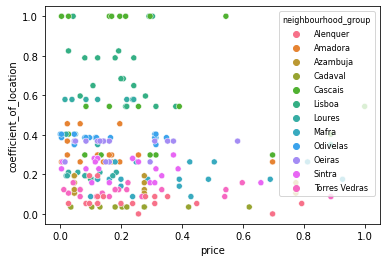

In [31]:
ax = sns.scatterplot(x="price", y="coefficient_of_location", data=new_data, hue = "neighbourhood_group")
plt.setp(ax.get_legend().get_texts(), fontsize='8') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='8') # for legend title

<ipython-input-30-5eded9e4c0f9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["cluster"]= clusters


[None, None]

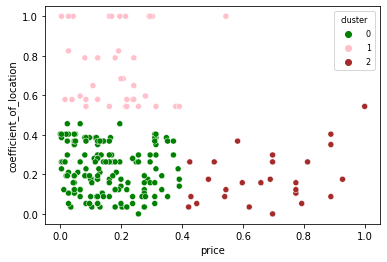

In [30]:
#defining the model
kmodel = KMeans(n_clusters=3, init='k-means++', max_iter=200, n_init=5, random_state=0)
#fitting the model
clusters = kmodel.fit_predict(df[["coefficient_of_location", "price"]])
df["cluster"]= clusters

ax = sns.scatterplot(x="price", y="coefficient_of_location", data=df, hue = "cluster", palette = ["green", "pink", "brown"])
plt.setp(ax.get_legend().get_texts(), fontsize='8') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='8') # for legend title